# Inverse model on FetchNoTask

## Instanciate and train the model

Create the environment.

In [1]:
import gym
import gym_robotics
from stable_baselines3.common.env_util import make_vec_env

n_envs = 1

env = make_vec_env("FetchNoTask-v1", n_envs=n_envs, env_kwargs=dict(image_obs_space=True))


In [2]:
from PIL import Image
import numpy as np

env.reset()
# actions = np.array([[0, 0, 0, 0], [1, 1, 1, 0]])
# obs0, rew, done, info = env.step(actions)
# actions = np.array([[0, 0, 0, 0], [1, 1, 1, 0]])
# obs1, rew, done, info = env.step(actions)
# actions = np.array([[0, 0, 0, 0], [1, 1, 1, 0]])
# obs2, rew, done, info = env.step(actions)


Found 3 GPUs for rendering. Using device 0.


array([[[[ 27,  28,  29],
         [ 27,  28,  29],
         [ 27,  28,  29],
         ...,
         [114, 218, 145],
         [114, 218, 145],
         [114, 218, 145]],

        [[ 72,  72,  73],
         [ 81,  81,  82],
         [ 81,  81,  82],
         ...,
         [114, 218, 145],
         [114, 218, 145],
         [114, 218, 145]],

        [[199, 199, 199],
         [210, 210, 210],
         [216, 216, 216],
         ...,
         [114, 218, 145],
         [114, 218, 145],
         [114, 218, 145]],

        ...,

        [[140, 140, 140],
         [140, 140, 140],
         [140, 140, 140],
         ...,
         [ 61,  61,  61],
         [ 88, 140, 103],
         [115, 220, 146]],

        [[140, 140, 140],
         [140, 140, 140],
         [140, 140, 140],
         ...,
         [ 75, 101,  82],
         [115, 220, 146],
         [115, 220, 146]],

        [[140, 140, 140],
         [140, 140, 140],
         [140, 140, 140],
         ...,
         [116, 220, 146],
        

Display an observation.

In [3]:
from IPython.display import display

# im = Image.fromarray(np.hstack((obs0[0], obs0[1],)))
# display(im)
# im = Image.fromarray(np.hstack((obs1[0], obs1[1],)))
# display(im)
# im = Image.fromarray(np.hstack((obs2[0], obs2[1],)))
# display(im)

Initilize the device.

In [4]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [5]:
import numpy as np

from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.vec_env import VecTransposeImage


buffer = ReplayBuffer(
    60_000, VecTransposeImage.transpose_space(env.observation_space), env.action_space, n_envs=n_envs, device=device
)

obs = VecTransposeImage.transpose_image(env.reset())
for _ in range(50_000//n_envs):
    actions = np.array([env.action_space.sample() for _ in range(n_envs)])

    _next_obs, rewards, dones, infos = env.step(actions)
    _next_obs = VecTransposeImage.transpose_image(_next_obs)
    next_obs = _next_obs.copy()

    for env_idx in range(n_envs):
        if dones[env_idx]:
            next_obs[env_idx] = VecTransposeImage.transpose_image(infos[env_idx]["terminal_observation"])

    buffer.add(obs, next_obs, actions, rewards, dones, infos)
    obs = _next_obs.copy()



In [6]:
buffer.pos

50000

Instanciate the model and the optimizer.

In [10]:
from go_explore.inverse_model import ConvInverseModel

from torch import optim

inverse_model = ConvInverseModel(action_size=env.action_space.shape[0], latent_size=6).to(device)
optimizer = optim.Adam(inverse_model.parameters(), lr=1e-3)

Train the model.

In [11]:
import torch.nn.functional as F


for epoch in range(5_000):
    # Sample
    sample = buffer.sample(32)
    observations = sample.observations.float() / 255
    next_observations = sample.next_observations.float() / 255
    actions = sample.actions

    # Compute the output image
    inverse_model.train()
    pred_actions = inverse_model(observations, next_observations)

    # Compute the loss
    loss = F.mse_loss(pred_actions, actions)

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print("epoch: {:5d}\tprediction loss: {:.5f}".format(epoch, loss.item()))

epoch:     0	prediction loss: 0.37299
epoch:   500	prediction loss: 0.35189
epoch:  1000	prediction loss: 0.18019
epoch:  1500	prediction loss: 0.20335
epoch:  2000	prediction loss: 0.23017
epoch:  2500	prediction loss: 0.15616
epoch:  3000	prediction loss: 0.08469
epoch:  3500	prediction loss: 0.14622
epoch:  4000	prediction loss: 0.12441
epoch:  4500	prediction loss: 0.11120


See the result for one transition.

true action		 tensor([[ 0.8778,  0.8408, -0.6026, -0.6051]], device='cuda:0')
predicted action	 tensor([[-6.6751e-03,  7.0016e-05, -1.1007e-02,  8.9878e-03]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
torch.Size([3, 168, 84])


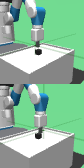

In [9]:
# Sample one transition
sample = buffer.sample(1)
observations = sample.observations.float() / 255
next_observations = sample.next_observations.float() / 255
actions = sample.actions

# Predict the action
inverse_model.eval()
pred_actions = inverse_model(observations, next_observations)

# See the result
print("true action\t\t", actions)
print("predicted action\t", pred_actions)

x = torch.dstack((sample.observations, sample.next_observations)).squeeze()
print(x.shape)
im = Image.fromarray(x.moveaxis(0, 2).detach().cpu().numpy())
display(im)

